In [ ]:
# Importando as blibiotecas
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook
import numpy as np
import pandas as pd

import warnings
warnings.filterwarnings('ignore')

from itertools import product

from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error

In [ ]:
url = 'https://raw.githubusercontent.com/aaasatoou/bootcamp_blue_Projeto2/main/Estudo%20COVID%20-%20Insights%20e%20Previs%C3%B5es/dados/Silver/datasets/serie%20temporal%20pais/S%C3%A9ries%20Temporais%20Argentina.csv'

serie_arg = pd.read_csv(url)
serie_arg.drop(['Unnamed: 0','Confirmed','Recovered','Ano'],axis=1,
               inplace=True)
serie_arg.head()

,Date,Deaths
0,2020-01-22,0
1,2020-01-23,0
2,2020-01-24,0
3,2020-01-25,0
4,2020-01-26,0


In [ ]:
# Selecionando apenas os primeiros meses do dataset
serie_arg = serie_arg[0:161]

In [ ]:
serie_arg['Date'] = pd.to_datetime(serie_arg['Date'],format='%Y-%m-%d')
serie_arg.set_index('Date',inplace=True)
serie_arg

,Deaths
Date,
2020-01-22,0
2020-01-23,0
2020-01-24,0
2020-01-25,0
2020-01-26,0
...,...
2020-06-26,1184
2020-06-27,1207
2020-06-28,1232


In [ ]:
treino = serie_arg[0:131]
treino

,Deaths
Date,
2020-01-22,0
2020-01-23,0
2020-01-24,0
2020-01-25,0
2020-01-26,0
...,...
2020-05-27,500
2020-05-28,508
2020-05-29,520


In [ ]:
teste = serie_arg[131:161]
teste.head()

,Deaths
Date,
2020-06-01,556
2020-06-02,569
2020-06-03,583
2020-06-04,608
2020-06-05,632


In [ ]:
def optimize_SARIMA(parameters_list, d, D, s, exog):
    
    results = []
    
    for param in tqdm_notebook(parameters_list):
        try: 
            model = SARIMAX(exog, order=(param[0], d, param[1]), seasonal_order=(param[2], D, param[3], s)).fit(disp=-1)
        except:
            continue
            
        aic = model.aic
        results.append([param, aic])
        
    result_df = pd.DataFrame(results)
    result_df.columns = ['(p,q)x(P,Q)', 'AIC']
    #Sort in ascending order, lower AIC is better
    result_df = result_df.sort_values(by='AIC', ascending=True).reset_index(drop=True)
    
    return result_df

In [ ]:
p = range(0, 5, 1)
d = 1
q = range(0, 5, 1)
P = range(0, 5, 1)
D = 1
Q = range(0, 5, 1)
s = 4
parameters = product(p, q, P, Q)
parameters_list = list(parameters)
print(len(parameters_list))

625


In [ ]:
result_df = optimize_SARIMA(parameters_list, 1, 1, 4, treino['Deaths'])
result_df

  0%|          | 0/625 [00:00<?, ?it/s]

,"(p,q)x(P,Q)",AIC
0,"(3, 3, 0, 4)",22.000000
1,"(1, 1, 1, 1)",626.071628
2,"(1, 1, 0, 2)",626.765909
3,"(1, 2, 1, 1)",627.172762
4,"(2, 1, 1, 1)",627.330617
...,...,...
436,"(0, 0, 0, 0)",696.377234
437,"(0, 1, 0, 0)",697.767214
438,"(1, 0, 0, 0)",697.818899
439,"(2, 0, 0, 0)",699.507575


In [ ]:
best_model = SARIMAX(treino['Deaths'], order=(1, 1, 1), seasonal_order=(0, 1, 2, 4)).fit(dis=-1)
print(best_model.summary())

                                       SARIMAX Results                                        
Dep. Variable:                                 Deaths   No. Observations:                  131
Model:             SARIMAX(1, 1, 1)x(0, 1, [1, 2], 4)   Log Likelihood                -308.383
Date:                                Mon, 16 Jan 2023   AIC                            626.766
Time:                                        15:43:42   BIC                            640.947
Sample:                                    01-22-2020   HQIC                           632.527
                                         - 05-31-2020                                         
Covariance Type:                                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9933      0.015     66.502      0.000       0.964       1.023
ma.

In [ ]:
fc = best_model.forecast(30, alpha=0.05)

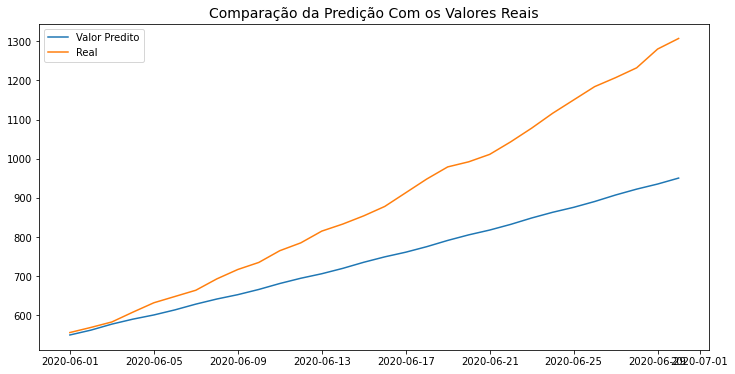

In [ ]:
plt.figure(figsize=(12,6))
plt.title('Comparação da Predição Com os Valores Reais', fontsize=14)
plt.plot(teste.index,fc,label='Valor Predito')
plt.plot(teste.index,teste['Deaths'].values,label='Real')
plt.legend()

In [ ]:
print('MAPE:',mean_absolute_percentage_error(teste['Deaths'],fc))
print('MAE:',mean_absolute_error(teste['Deaths'],fc))
print('RMSE:',np.sqrt(mean_squared_error(teste['Deaths'],fc)))

MAPE: 0.14480468248031833
MAE: 147.64215264182957
RMSE: 182.6008542014283
